In [2]:
import tensorflow as tf
import numpy as np # for numerical operations and linear algebra
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from typing import Tuple
from tqdm import tqdm


image_dir = "datasetImages_warp256/datasetImages_warp256/"
label_csv_path = "label/"


batch_size = 32
epochs = 50




ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import os
arr = os.listdir(image_dir)
print(arr)

['farm1_255_19452343093_8ee7e5e375_b.jpg', 'farm1_255_19505039284_0d64350b48_b.jpg', 'farm1_255_19536285083_0c105b0e12_b.jpg', 'farm1_255_19547508993_5f548dce33_b.jpg', 'farm1_255_19587663613_5434654e28_b.jpg', 'farm1_255_19591276064_e10b2b4791_b.jpg', 'farm1_255_19645548243_8513acc505_b.jpg', 'farm1_255_19662764583_8e52368f78_b.jpg', 'farm1_255_19793534070_9fffbaed5d_b.jpg', 'farm1_255_19802656010_dfd96ba320_b.jpg', 'farm1_255_19902508368_481b71a0d5_b.jpg', 'farm1_255_19907767598_8ed2936360_b.jpg', 'farm1_255_19917776758_50905c3bba_b.jpg', 'farm1_255_19924400869_73b1404107_b.jpg', 'farm1_255_19947313370_82d8be746c_b.jpg', 'farm1_255_19986518659_ebca86e75c_b.jpg', 'farm1_255_19986805059_3d99b9140e_b.jpg', 'farm1_255_20000684160_c00b7950ff_b.jpg', 'farm1_255_20014102720_76f87768e5_b.jpg', 'farm1_255_20014798818_fcca391342_b.jpg', 'farm1_255_20015935300_af939f0c28_b.jpg', 'farm1_255_20016161619_eb4338c145_b.jpg', 'farm1_255_20024923990_67060baf00_b.jpg', 'farm1_255_20073269062_d169b4f946

In [ ]:
toPILImage = lambda x: tf.keras.preprocessing.image.array_to_img(x)

In [ ]:
class AADB(tf.keras.utils.Sequence):
    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score",
    ]

    def preprocess_image(self, image):       
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255.0
        return image

    def __init__(self, image_dir, label_csv_path, batch_size=32, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.test = test

        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert('RGB')
        image = self.preprocess_image(image)
        image = tf.convert_to_tensor(image)  # Convert PIL Image to TensorFlow tensor
        assert image.shape == (256, 256, 3)
        label = tf.convert_to_tensor(self.labels[index], dtype=tf.float32)
        return image, label

    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows():  # this is for moving score to the last value
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)

        # Moving 'score' to the last column
        labels = np.asarray(labels)
        return files, labels


In [ ]:
aadb = AADB(image_dir, label_csv_path)

In [ ]:
def show_example(img, label):
    print(label)
    plt.imshow(toPILImage(img))
    plt.show()

In [ ]:
def show_batch(dataset):
    for images, labels in dataset.take(1):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        images = tf.concat(tf.unstack(images, axis=0), axis=1)  # Concatenate images horizontally
        ax.imshow(images)
        break

In [ ]:
# show_example(*aadb[0])
# len(aadb)

In [ ]:


#train_ds, val_ds = random_split(aadb, [train_size, val_size])
#train_ds, val_ds = tf.data.Dataset.from_tensor_slices(aadb.files[:train_size]), tf.data.Dataset.from_tensor_slices(aadb.files[train_size:])
val_size = 500
train_size = len(aadb.files) - val_size

train_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).take(train_size)

val_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).skip(train_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# show_batch(train_ds)



In [ ]:
class RankLoss(tf.keras.losses.Loss):

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        # Calculate target
        target = tf.ones_like(y_true[0], dtype=y_pred[0].dtype)

        # Set indices where y_true1 < y_true2 to -1
        target = tf.where(y_true[0] < y_true[1], -1.0 * tf.ones_like(target), target)

        # Calculate margin ranking loss
        loss = tf.maximum(0.0, self.margin - (y_pred[0] - y_pred[1]) * target)
        return tf.reduce_mean(loss)




class RegRankLoss(tf.keras.losses.Loss):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.rank_loss = RankLoss(margin)

    def __call__(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank
    
    

In [ ]:
import tensorflow as tf

def create_backbone(backbone_name, pretrained=True):
    """
    Creates a backbone model from a pre-trained model.
    Args:
        backbone_name (str): Name of the backbone model (e.g., 'resnet50').
        pretrained (bool): Whether to use pre-trained weights.
    Returns:
        tf.keras.Model: The backbone model.
    """
    backbone = getattr(tf.keras.applications, backbone_name)(
        include_top=False,
        weights='imagenet' if pretrained else None,
        input_shape=(256, 256, 3)  # Replace with your input shape
    )
    backbone.trainable = False  # Freeze the backbone layers
    return backbone

    
def create_regression_network(backbone, num_attributes):
    """
    Creates a regression network using the given backbone.
    Args:
        backbone (tf.keras.Model): The backbone model.
        num_attributes (int): Number of attributes for the regression task.
    Returns:
        tf.keras.Model: The regression network.
    """
    inputs = backbone.input
    x = backbone.output

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_attributes, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)

    return model


In [ ]:

#model = RegressionNetwork(backbone='ResNet50', num_attributes=len(attributes), pretrained=False)
model = create_regression_network(create_backbone('MobileNetV2', pretrained=False), 12)


In [ ]:
loss_fn = RegRankLoss(margin=0.02)

In [ ]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

train_losses = []
train_losses_reg = []
train_losses_rank = []
val_losses = []
num_batches = train_size // (batch_size * 2)  # Calculate the number of batches
pbar = tqdm(enumerate(train_ds), total=num_batches)

for epoch in range(epochs):
    for batch, (x, y) in pbar:
        with tf.GradientTape() as tape:
            x1, x2 = tf.split(x, 2, axis=0)
            y1, y2 = tf.split(y, 2, axis=0)
            y_pred1 = model(x1, training=True)
            y_pred2 = model(x2, training=True)

            loss, loss_reg, loss_rank = loss_fn(y_pred=(y_pred1, y_pred2), y_true=(y1, y2))
           
            pbar.set_description("Epoch {}, Reg Loss: {:.4f}, Rank Loss: {:.4f} ".format(epoch, float(loss_reg), float(loss_rank)))

        train_losses.append(loss.numpy())
        train_losses_reg.append(loss_reg.numpy())
        train_losses_rank.append(loss_rank.numpy())
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epoch 0, Reg Loss: 0.0909, Rank Loss: 0.0817 : : 265it [01:14,  3.54it/s]                       


In [ ]:
pbar = tqdm(enumerate(val_ds), total=val_size // batch_size)
for batch, (x, y) in pbar:
    y_pred = model(x, training=False)
    loss, _, _ = loss_fn(y_pred, y)
    val_losses.append(loss.numpy())
    pbar.set_description(f'Val Loss: {np.mean(val_losses):.4f}')

Val Loss: 0.3044: : 16it [00:23,  1.47s/it]                      


Label: {'balancing_elements': 0.0, 'color_harmony': 0.0, 'content': -0.833, 'depth_of_field': -0.167, 'light': -0.5, 'motion_blur': 0.0, 'object': -1.0, 'repetition': 0.0, 'rule_of_thirds': -0.333, 'symmetry': -0.167, 'vivid_color': 0.208, 'score': 0.0}
Prediction: {'balancing_elements': 0.0016699882, 'color_harmony': 0.010811651, 'content': 0.008772048, 'depth_of_field': 0.0024359946, 'light': 0.00038589336, 'motion_blur': -0.0003972117, 'object': 0.0023893483, 'repetition': 0.002330809, 'rule_of_thirds': -7.383421e-05, 'symmetry': -8.505481e-05, 'vivid_color': 0.021367628, 'score': 0.0009820971}


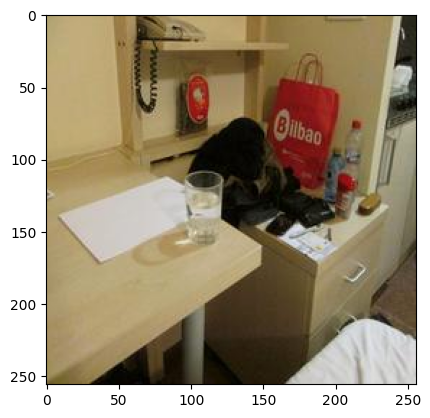

Label: {'balancing_elements': 0.0, 'color_harmony': 0.6, 'content': 0.8, 'depth_of_field': 0.2, 'light': 0.0, 'motion_blur': 0.2, 'object': 0.0, 'repetition': 0.0, 'rule_of_thirds': 0.2, 'symmetry': 0.0, 'vivid_color': 0.75, 'score': 0.0}
Prediction: {'balancing_elements': 0.0016699882, 'color_harmony': 0.010811651, 'content': 0.008772048, 'depth_of_field': 0.0024359946, 'light': 0.00038589336, 'motion_blur': -0.0003972117, 'object': 0.0023893483, 'repetition': 0.002330809, 'rule_of_thirds': -7.383421e-05, 'symmetry': -8.505481e-05, 'vivid_color': 0.021367628, 'score': 0.0009820971}


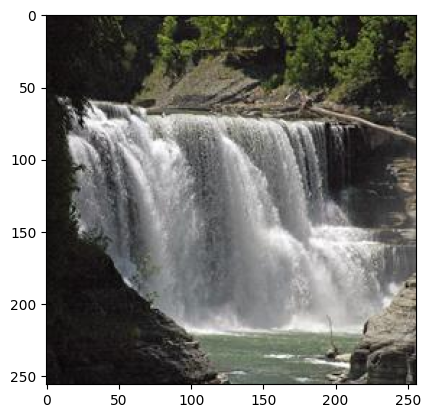

Label: {'balancing_elements': 0.0, 'color_harmony': 0.2, 'content': 0.4, 'depth_of_field': -0.2, 'light': 0.2, 'motion_blur': 0.2, 'object': 0.2, 'repetition': 0.0, 'rule_of_thirds': -0.4, 'symmetry': -0.2, 'vivid_color': 0.5, 'score': 0.2}
Prediction: {'balancing_elements': 0.0016699882, 'color_harmony': 0.010811651, 'content': 0.008772048, 'depth_of_field': 0.0024359946, 'light': 0.00038589336, 'motion_blur': -0.0003972117, 'object': 0.0023893483, 'repetition': 0.002330809, 'rule_of_thirds': -7.383421e-05, 'symmetry': -8.505481e-05, 'vivid_color': 0.021367628, 'score': 0.0009820971}


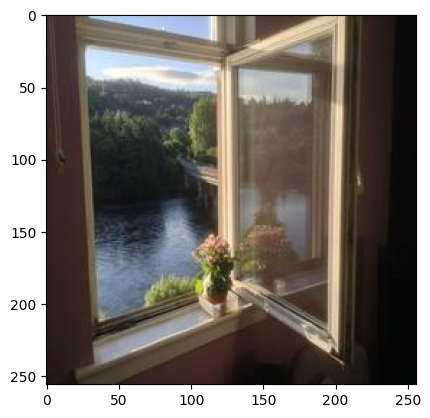

In [ ]:
attributes = [
    "balancing_elements",
    "color_harmony",
    "content",
    "depth_of_field",
    "light",
    "motion_blur",
    "object",
    "repetition",
    "rule_of_thirds",
    "symmetry",
    "vivid_color",
    "score",
]

def show_predictions(dataset, num_samples=3):
    for images, labels in dataset.take(1):
        predictions = model(images, training=False)
        for i in range(num_samples):
            image = toPILImage(images[i])
            label = {attribute: value for attribute, value in zip(attributes, labels[i].numpy())}
            prediction = {attribute: value for attribute, value in zip(attributes, predictions[i].numpy())}
            print(f'Label: {label}')
            print(f'Prediction: {prediction}')
            plt.imshow(image)
            plt.show()

show_predictions(val_ds)


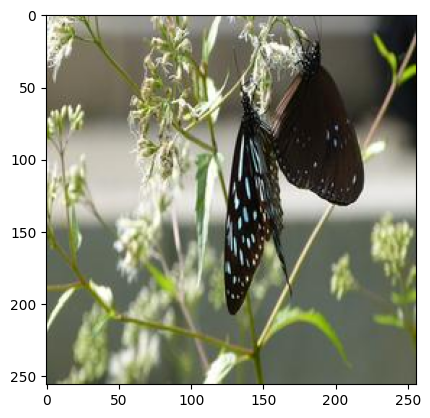

Prediction: {'balancing_elements': 0.0016699882, 'color_harmony': 0.010811651, 'content': 0.008772048, 'depth_of_field': 0.0024359946, 'light': 0.00038589336, 'motion_blur': -0.0003972117, 'object': 0.0023893483, 'repetition': 0.002330809, 'rule_of_thirds': -7.383421e-05, 'symmetry': -8.505481e-05, 'vivid_color': 0.021367628, 'score': 0.0009820971}


In [ ]:
def show_prediction_custom(image_path):
    image = Image.open(image_path).convert('RGB')
    image = aadb.preprocess_image(image)
    image = tf.expand_dims(image, axis=0)
    prediction = model(image, training=False).numpy()[0]
    prediction = {attribute: value for attribute, value in zip(attributes, prediction)}
    plt.imshow(toPILImage(image[0]))
    plt.show()
    print(f'Prediction: {prediction}')

show_prediction_custom('datasetImages_warp256/datasetImages_warp256/farm1_255_19452343093_8ee7e5e375_b.jpg')


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = "model.tflite"  # File path where you want to save the TFLite model
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)
    

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd1ah_382\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd1ah_382\assets
